In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
from IPython import get_ipython
from IPython.display import display
from tqdm import tqdm
import random
import math
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence



In [3]:
class Configuration:
    """
    settings and parameters for the model and data processing.
    """
    def __init__(self):
        args = self._fetch_settings()
        self._apply_settings(args)
        self.device = self._determine_device()
        self.model_directory = self._prepare_model_directory()
        self._persist_settings(args)
        self._initialize_random_seeds(self.seed)

    def _fetch_settings(self):
        """
        Collects command-line arguments for configuration.
        """
        settings = {
            'data_dir': './drive/MyDrive/nlp/textmining_CW/data',
            'output_dir': './drive/MyDrive/nlp/textmining_CW/output',
            'embedding_path': './drive/MyDrive/nlp/textmining_CW/embedding/glove.6B.100d.txt',
            'word_dim': 100,
            'model_name': 'Att_LSTM',
            'mode': 1,
            'seed': 20250215,
            'cuda': 0,
            'epoch': 10,
            'batch_size': 10,
            'lr': 1,
            'max_len': 100,
            'emb_dropout': 0.3,
            'lstm_dropout': 0.3,
            'linear_dropout': 0.5,
            'hidden_size': 100,
            'layers_num': 1,
            'num_heads': 4,
            'L2_decay': 1e-5,
        }
        # using argparse.Namespace to create obj
        args = argparse.Namespace(**settings)
        return args

    def _apply_settings(self, args):
        """
        Assigns the fetched settings to the class attributes.
        """
        for k,v in args.__dict__.items():
            setattr(self,k,v)

    def _determine_device(self):
        """
        Identifies and returns the device
        """
        device_name = f"cuda:{self.cuda}" if torch.cuda.is_available() else "cpu"
        return torch.device(device_name)

    def _prepare_model_directory(self):
        """
        Constructs and creates the directory for saving model data.
        """
        directory=os.path.join(self.output_dir,self.model_name)
        os.makedirs(directory,exist_ok=True)
        return directory

    def _persist_settings(self, args):
        """
        Stores the configuration settings in a JSON file for reference.
        """
        config_paths = os.path.join(self.model_directory, 'config.json')
        with open(config_paths, 'w', encoding='UTF-8') as file:
            json.dump(vars(args), file, ensure_ascii=False)

    def _initialize_random_seeds(self, seed):
        """
        Sets the random number generator seeds for consistency.
        """
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        random.seed(seed)
        np.random.seed(seed)
        os.environ['PYTHONHASHSEED']=str(seed)

    def display_settings(self):
        """
        Prints the current configuration settings.
        """
        for key_item,value_item in self.__dict__.items():
            print("{}--->>{}".format(key_item,value_item))

In [10]:
class EnhancedAttention(nn.Module):
    """
    An advanced Multi-Head Attention mechanism that allows for a more nuanced
    understanding of relationships within sequences.
    """

    def __init__(self, model_dim, head_num, Dropout_Rate=0.1):
        super().__init__()
        self.head_num=head_num
        self.key_dim=model_dim//head_num
        self.query_transform =nn.Linear(model_dim,model_dim)
        self.key_transform =nn.Linear(model_dim,model_dim)
        self.value_transform=nn.Linear(model_dim,model_dim)
        self.output_transform=nn.Linear(model_dim,model_dim)
        self.dropout=nn.Dropout(Dropout_Rate)

    def _calculate_attention(self,query,key,value,mask=None):
        """
        Performs the calculation.
        """
        attention_scores0=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(self.key_dim)
        if mask is not None:
            attention_scores1=attention_scores0.masked_fill(mask==0,-1e9)
        # Normalize the attention scores
        attention_weights1 =F.softmax(attention_scores1,dim=-1)
        attention_weights2 =self.dropout(attention_weights1)#regularization
        return torch.matmul(attention_weights2, value)

    def _split_heads(self,tensor):
        """
        Divide the input tensors for parallel processing.
        """
        batch_size,seq_len,model_dim=tensor.size()
        return tensor.view(batch_size,seq_len,self.head_num, self.key_dim).transpose(1,2)

    def _merge_heads(self, tensor):
        """
        Combines the output into a single tensor.
        """
        batch_size, _, seq_len, key_dim=tensor.size()
        return tensor.transpose(1,2).contiguous().view(batch_size,seq_len,self.head_num* key_dim)

    def forward(self, query, key, value, mask=None):
        """
        forward pass through Multti-Head Attention.
        """
        # Apply linear transformations
        query,key,value=self.query_transform(query),self.key_transform(key),self.value_transform(value)
        query_split, key_split, value_split=self._split_heads(query), self._split_heads(key), self._split_heads(value)
        #If a mask is provided, expand it to the correct shape
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(1).expand(-1, self.head_num, -1, -1).bool()
        #attention output
        output_split = self._calculate_attention(query_split, key_split, value_split, mask)
        # Merge the output
        output = self._merge_heads(output_split)
        return self.output_transform(output)


class AttentiveLSTM(nn.Module):
    """
    A sophisticated neural network model that leverages an LSTM for sequential
    processing and incorporates attention mechanisms。
    """

    def __init__(self, word_embeddings, num_classes, settings):
        super().__init__()
        self.word_embeddings = word_embeddings #pre-trained word embeddings
        self.num_classes = num_classes
        self.max_sequence_length = settings.max_len
        self.embedding_dim = settings.word_dim
        self.lstm_hidden_size = settings.hidden_size
        self.embedding_dropout = nn.Dropout(settings.emb_dropout)# Dropout layer for embeddings
        self.lstm_dropout = nn.Dropout(settings.lstm_dropout)
        self.linear_dropout = nn.Dropout(settings.linear_dropout)
        self.attention_heads = settings.num_heads #num of attention heads
        #the specific params and set the freeze to false
        self.embedding_layer =nn.Embedding.from_pretrained(embeddings=self.word_embeddings, freeze=False)

        #sequential processing
        self.lstm_layer =nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_hidden_size,
            batch_first=True,
            num_layers=settings.layers_num,
            bidirectional=False
        )
        #attention mechanism
        self.attention_mechanism=EnhancedAttention(self.lstm_hidden_size,self.attention_heads)
        self.output_layer=nn.Linear(in_features=self.lstm_hidden_size,out_features=self.num_classes)
        # Initialize weights and biases
        init.xavier_normal_(self.output_layer.weight)
        init.constant_(self.output_layer.bias, 0.)

    def _process_with_lstm(self, input_data, mask):
        """
        Processes the input through the LSTM layers with the proper handling
        of masked sequences.
        """
        len_total = torch.sum(mask.gt(0),dim=-1).cpu().type(torch.int64)
        packinput_inf = pack_padded_sequence(input_data,len_total,batch_first=True,enforce_sorted=False)
        lstm_out, _ =self.lstm_layer(packinput_inf)
        # batch_first=True: Indicates that the first dimension of the output should be the batch size.
        # padding_value=0.0: The value used to pad the sequences.
        unpacked_output, _= pad_packed_sequence(lstm_out,batch_first=True,padding_value=0.0,total_length=self.max_sequence_length)
        return unpacked_output

    def forward(self, input_data):
        """
        Defines the flow of data through the network, from input to the final output.
        """
        tokens = input_data[:, 0, :].squeeze(1)
        mask = input_data[:, 1, :].squeeze(1)
        embedded_tokens = self.embedding_dropout(self.embedding_layer(tokens))
        lstm_hide_states = self.lstm_dropout(self._process_with_lstm(embedded_tokens, mask))
        attended_states = self.attention_mechanism(lstm_hide_states, lstm_hide_states, lstm_hide_states,mask)
        mean_attended_states = torch.mean(attended_states, dim=1)
        regularized_states = self.linear_dropout(mean_attended_states)
        return self.output_layer(regularized_states)

In [8]:
class EmbeddingInitializer:
    """
    Loads and prepares pre-trained word embeddings for use in the model.
    """

    def __init__(self,config):
        self.embedding_filepath=config.embedding_path
        self.embedding_dimension=config.word_dim

    def prepare_embeddings(self):
        """
        Loads pre-trained word vectors, creates a word-to-ID mapping, and
        returns them formatted for use.
        """
        word_to_id, word_vectors = self._read_embeddings()
        word_vectors = self._refine_embeddings(word_vectors)
        return word_to_id, word_vectors

    def _read_embeddings(self):
        """
        Reads the word embedding file and constructs the word-to-ID mapping
        along with the vector representation for each word.
        """
        word_to_id = {'PAD': 0, 'UNK': 1, '<e1>': 2, '<e2>': 3, '</e1>': 4, '</e2>': 5}
        wor_vectors = []

        with open(self.embedding_filepath, 'r', encoding='UTF-8') as file:
          for line in file:
            elements = line.strip().split()
            if len(elements)==self.embedding_dimension+1:
                word, vector=elements[0], np.array(elements[1:],dtype=np.float32)
                word_to_id[word]=len(word_to_id)
                wor_vectors.append(vector)

        return word_to_id, wor_vectors

    def _refine_embeddings(self, word_vectors):
        """
        Performs final adjustments to the embedding matrix, including special
        tokens and normalization.
        """
        word_vectors = np.stack(word_vectors)
        vector_mean, vector_std = word_vectors.mean(), word_vectors.std()
        special_vectors = np.random.normal(vector_mean, vector_std, (6, self.embedding_dimension))
        special_vectors[0] = 0
        word_vectors = np.concatenate((special_vectors, word_vectors), axis=0)
        return torch.from_numpy(word_vectors.astype(np.float32))


class RelationIdentifier:
    """
    Handles the loading and management of the relationship type data.
    """

    def __init__(self, config):
        self.folder_path=config.data_dir

    def fetch_relation_data(self):
        """
        Returns the relationship-to-ID and ID-to-relationship mappings,
        as well as the num() of relations.
        """
        return self._load_relation_data()

    def _load_relation_data(self):
        """
        Reads the relation2id.txt file to build the mappings between
        relationships and their respective IDs.
        """
        relation_info=os.path.join(self.folder_path,'relation_with_id.txt')
        return self._read_relation_file(relation_info)

    def _read_relation_file(self, filepath):
        """
        Reads the relation file and returns relation-to-id and id-to-relation mappings.
        """
        relation_to_id, id_to_relation = {}, {}
        try:
          with open(filepath, 'r', encoding='UTF-8') as file:
            for line in file:
                relation, id_str = line.strip().split()
                relation_id = int(id_str)
                relation_to_id[relation] = relation_id
                id_to_relation[relation_id] = relation
          return relation_to_id, id_to_relation, len(relation_to_id)
        except FileNotFoundError:
          print(f"Error: Relation file not found at '{filepath}'")
          return {}, {}, 0
        except ValueError:
          print(f"Error: Invalid format in relation file '{filepath}'.")
          return {}, {}, 0
        except Exception as e:
          print(f"An unexpected error occurred: {e}")
          return {},{},0


class SemEvalData(Dataset):
    """
    A class that is designed to handle SemEval_data for RE.
    """

    def __init__(self, filename, relation_map, word_map, config):
        self.filename = filename
        self.relation_map = relation_map
        self.word_map = word_map
        self.max_sequence_length = config.max_len
        self.data_folder = config.data_dir
        self.data, self.labels = self._load_and_prepare_data()

    def _load_and_prepare_data(self):
        """
        deal the data from a specified JSON,
        preparing it to the model_training.
        """
        data_filepath = os.path.join(self.data_folder,self.filename)
        return self._load_json_data(data_filepath)

    def _load_json_data(self, filepath):
        """
        read data from a JSON and preprocesses each sentence.
        """
        dataset, labels = [], []
        with open(filepath, 'r', encoding='UTF-8') as file:
          for line in file:
            item = json.loads(line.strip())
            dataset.append(self._numericalize_sentence(item['sentence']))
            labels.append(self.relation_map[item['relation']])
        return dataset, labels

    def _numericalize_sentence(self, sentence):
        """
        Converts a sentence into a numerical representation using word IDs
        and constructs a corresponding mask.
        """
        numerical_tokens = self._convert_sentence_to_ids(sentence)
        masks = self._create_mask(sentence)
        # Stack the arrays along a new axis
        data_unit = np.stack([numerical_tokens, masks])
        # Reshape the result to (1, 2, max_sequence_length)
        return data_unit.reshape(1, 2, self.max_sequence_length)

    def _convert_sentence_to_ids(self, sentence):
        """
        sentence to a sequence of word_IDs, padding it to the max length.
        """
        valid_length = min(self.max_sequence_length, len(sentence))
        numerical_tokens = [self.word_map.get(word.lower(), self.word_map['UNK']) for word in sentence[:valid_length]]
        numerical_tokens += [self.word_map['PAD']] * (self.max_sequence_length - valid_length)
        return numerical_tokens

    def _create_mask(self, sentence):
        """
        Creates a mask for the sentence, indicating the valid tokens.
        """
        mask=[1]*min(self.max_sequence_length,len(sentence))
        mask+=[0]*(self.max_sequence_length-len(mask))
        return mask

    def __getitem__(self, index):
        """
        get data sample and its label from the dataset.
        """
        return self.data[index],self.labels[index]

    def __len__(self):
        """
        the total num of samples
        """
        return len(self.labels)


class DataDistributor:
    """
    A utility class for managing the loading and distribution of SemEval
    dataset batches.
    """

    def __init__(self, relation_map, word_map, config):
        self.relation_map = relation_map
        self.word_map = word_map
        self.config = config

    def _collate_data(self, batch):
        """
        Custom collate function to assemble data into batches suitable for
        model input.
        """
        data, label = zip(*batch)
        data = torch.from_numpy(np.concatenate(data, axis=0))
        label = torch.tensor(label, dtype=torch.int64)
        return data, label

    def _create_data_loader(self, filename, shuffle=False):
        """
        Builds and returns a DataLoader for a specified data file.
        """
        dataset = SemEvalData(filename, self.relation_map, self.word_map, self.config)
        return DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=shuffle,
            collate_fn=self._collate_data,
            num_workers=0,
        )

    def fetch_training_data(self):
        """
        returns dataLoader for training
        """
        return self._create_data_loader('train.json', shuffle=True)

    def fetch_validation_data(self):
        """
        validation dataset
        """
        return self._create_data_loader('test.json', shuffle=False)

    def fetch_testing_data(self):
        """
        testing dataset
        """
        return self._create_data_loader('test.json', shuffle=False)

In [ ]:
def compute_macro_metrics(predicted_labels, true_labels, num_classes=10):
    """
    Calculates the metrics: precision recall and F1
    """
    assert true_labels.shape[0] == predicted_labels.shape[0]
    matrix = _compute_confusion_matrix(predicted_labels, true_labels, num_classes)
    precision_scores, recall_scores, f1_scores = _compute_class_metrics(matrix)
    macro_precision, macro_recall, macro_f1 = _compute_macro_averages(precision_scores, recall_scores, f1_scores)
    return macro_precision, macro_recall, macro_f1

def _compute_confusion_matrix(predicted_labels, true_labels, num_classes):
    """
    Computes the matrix for the given predicted and true labels
    """
    matrix0=np.zeros((num_classes,num_classes), dtype=np.float32)#create 0 matrix
    diagonal_mismatch=np.zeros(num_classes, dtype=np.float32)
    for i in range(true_labels.shape[0]):
        true_index = math.ceil(true_labels[i] / 2)
        predicted_index = math.ceil(predicted_labels[i] / 2)
        if true_labels[i] == predicted_labels[i]:
            matrix0[predicted_index][true_index] += 1
        elif true_index == predicted_index:
            diagonal_mismatch[predicted_index] += 1
        else:
            matrix0[predicted_index][true_index] += 1
    return matrix0, diagonal_mismatch

def _compute_class_metrics(matrix_and_mismatch):
    """
     precision, recall, F1 score
    """
    matrix, diagonal_mismatch = matrix_and_mismatch
    num_classes = matrix.shape[0]
    # col's and row's nums
    col_sums = np.sum(matrix,axis=0).reshape(-1)
    row_sums = np.sum(matrix,axis=1).reshape(-1)
    precision_scores = np.zeros(num_classes, dtype=np.float32)
    recall_scores = np.zeros(num_classes, dtype=np.float32)
    f1_scores = np.zeros(num_classes, dtype=np.float32)

    for i in range(1, num_classes):
        try:
            precision = float(matrix[i][i]) / float(col_sums[i] + diagonal_mismatch[i])
            recall = float(matrix[i][i]) / float(row_sums[i] + diagonal_mismatch[i])
            precision_scores[i] = precision
            recall_scores[i] = recall
            f1_scores[i] = (2 * precision * recall / (precision + recall))
        except ZeroDivisionError:
            pass
    return precision_scores, recall_scores, f1_scores

def _compute_macro_averages(precision_scores, recall_scores, f1_scores):
    """
    Computes macro-averaged precision, recall, and F1 score
    """
    effective_classes = sum(1 for score in f1_scores[1:] if score > 0)
    macro_precision = sum(score for score in precision_scores[1:] if score > 0) / effective_classes if effective_classes > 0 else 0.0
    macro_recall = sum(score for score in recall_scores[1:] if score > 0) / effective_classes if effective_classes > 0 else 0.0
    macro_f1 = sum(score for score in f1_scores[1:] if score > 0) / effective_classes if effective_classes > 0 else 0.0
    return macro_precision,macro_recall,macro_f1

class ModelEvaluator:
    """
    evalua the performance of the model during train and test.
    """

    def __init__(self, config):
        self.device = config.device

    def assess_model(self, model, loss_function, data_loader):
      model.eval()
      predictions, truths = [], []
      total_loss_=0.0
      with torch.no_grad():
          for d, l in data_loader:
              data, label = d.to(self.device), l.to(self.device)
              logits = model(data)
              loss_ = loss_function(logits, label)
              total_loss_ += loss_.item() * logits.shape[0]

              predicted=torch.max(logits,dim=1)[1].cpu().numpy().reshape((-1, 1))
              label_2=label.cpu().numpy().reshape((-1, 1))
              predictions.append(predicted)
              truths.append(label_2)

      avg_loss = total_loss_ / len(data_loader.dataset)
      predictions =np.concatenate(predictions, axis=0)
      truths = np.concatenate(truths, axis=0)
      precision,recall,f1=compute_macro_metrics(predictions, truths)
      return precision, recall, f1, avg_loss, predictions

In [ ]:
def write_predictions_to_file(predicted_labels, id_to_relation, start_index=8001):
    """
    Writes the predicted relations for each sample to a text file,
    formatted for submission or analysis.
    """
    with open('./drive/MyDrive/nlp/textmining_CW/predicted_result.txt', 'w', encoding='UTF-8') as file:
        for i, prediction in enumerate(predicted_labels):
            file.write(f"{start_index + i}\t{id_to_relation[int(prediction)]}\n")


def plot_training(train_losses,dev_losses,f1_scores):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(13, 5))
    #figure 1: loss
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, dev_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Trends')
    plt.legend()

    #figure 2: f1
    plt.subplot(1,2,2)
    plt.plot(epochs, f1_scores, label='Macro F1 on Validation', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1 Score')
    plt.title('Macro F1 Score on Validation Set')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model, loss_function, data_loaders, config):

    train_loader, dev_loader, _ = data_loaders
    optimizer_ = optim.Adadelta(model.parameters(), lr=config.lr, weight_decay=config.L2_decay)
    evaluator = ModelEvaluator(config)
    #empty list for storing the result
    train_losses, dev_losses, f1_scores = [],[],[]
    train_precision_scores,train_recall_scores = [],[]
    dev_precision_scores, dev_recall_scores = [],[]

    print("Model Architecture Overview:")
    print(model)
    print("\nModel Parameters Ready for Training:")
    for name, para in model.named_parameters():
        if para.requires_grad:
            print(f"{name}: {para.data.shape}")
    #edge
    print("-"*30)
    print("Beginning the Model Training Process...")

    for epoch in range(1, config.epoch + 1):
        model.train()
        train_loader_progress = tqdm(train_loader, desc=f'Epoch {epoch}/{config.epoch}', leave=False)
        for data,label in train_loader_progress:
            data,label = data.to(config.device), label.to(config.device)
            optimizer_.zero_grad()
            logits = model(data)
            loss = loss_function(logits, label)
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), clip_value=5)
            optimizer_.step()
            train_loader_progress.set_postfix(loss=loss.item())

        dev_precision, dev_recall, f1, dev_loss, _ = evaluator.assess_model(model, loss_function, dev_loader)
        train_precision, train_recall, _, train_loss, _ = evaluator.assess_model(model, loss_function, train_loader)

        train_losses.append(train_loss)
        dev_losses.append(dev_loss)
        f1_scores.append(f1)
        train_precision_scores.append(train_precision)
        train_recall_scores.append(train_recall)
        dev_precision_scores.append(dev_precision)
        dev_recall_scores.append(dev_recall)

        print("[{:03d}] train_loss: {:.3f} | dev_loss: {:.3f} | train_precision: {:.4f} | train_recall: {:.4f} | dev_precision: {:.4f} | dev_recall: {:.4f} | micro f1 on dev: {:.4f}".format(epoch, train_loss, dev_loss, train_precision, train_recall, dev_precision, dev_recall, f1), end=' ')
        if epoch == config.epoch:
            torch.save(model.state_dict(), os.path.join(config.model_directory, 'final_model.pkl'))
            print('>>> The Final Model has been Saved!')
        else:
            print()

    plot_training(train_losses,dev_losses,f1_scores)


def evaluate_model(model, loss_function, data_loaders, config):

    print("-" * 30)
    print("Initiating the Model Testing Phase...")
    _, _, test_loader = data_loaders
    model.load_state_dict(torch.load(os.path.join(config.model_directory, 'final_model.pkl')))
    evaluator = ModelEvaluator(config)
    # Unpack all five values returned by assess_model
    precision, recall, f1, test_loss, predicted_labels = evaluator.assess_model(model, loss_function, test_loader)
    print("test_loss: {:.3f} | micro f1 on test: {:.4f}".format(test_loss,f1))
    return predicted_labels

In [4]:
def prepare_input_sentence(sentence, word_to_id, max_length):
    """
    Preprocesses a sentence for input to the model, converting it into a
    numerical representation.
    """
    tokens = sentence.strip().split()
    token_ids = [word_to_id.get(token.lower(), word_to_id['UNK']) for token in tokens]
    token_ids_2 = token_ids+[word_to_id['PAD']]*(max_length-len(token_ids)) if len(token_ids)<max_length else token_ids[:max_length]
    mask = [1] * len(tokens) + [0] * (max_length - len(tokens))
    mask = mask[:max_length]
    token_ids_3 = torch.tensor([token_ids_2], dtype=torch.long)
    mask = torch.tensor([mask], dtype=torch.long)
    data = torch.stack([token_ids_3, mask], dim=1)
    return data


def determine_relation(sentence, model, word_to_id, id_to_relation, config):
    """
    Predicts the relation label for a given input sentence using the
    trained model.
    """
    data = prepare_input_sentence(sentence, word_to_id, config.max_len).to(config.device)
    model.eval()
    with torch.no_grad():
        logits = model(data)
        prediction = torch.max(logits,dim=1)[1].cpu().item()
    return id_to_relation[prediction]

------------------------------
Operational Configuration Settings:
data_dir--->>./drive/MyDrive/nlp/textmining_CW/data
output_dir--->>./drive/MyDrive/nlp/textmining_CW/output
embedding_path--->>./drive/MyDrive/nlp/textmining_CW/embedding/glove.6B.100d.txt
word_dim--->>100
model_name--->>Att_LSTM
mode--->>1
seed--->>20250215
cuda--->>0
epoch--->>10
batch_size--->>10
lr--->>1
max_len--->>100
emb_dropout--->>0.3
lstm_dropout--->>0.3
linear_dropout--->>0.5
hidden_size--->>100
layers_num--->>1
num_heads--->>4
L2_decay--->>1e-05
device--->>cuda:0
model_directory--->>./drive/MyDrive/nlp/textmining_CW/output/Att_LSTM
------------------------------
Loading and Processing Data...
Data Loading and Preparation Completed!
------------------------------
Model Architecture Overview:
AttentiveLSTM(
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (lstm_dropout): Dropout(p=0.3, inplace=False)
  (linear_dropout): Dropout(p=0.5, inplace=False)
  (embedding_layer): Embedding(400006, 100)
  (lstm_lay

<ipython-input-6-ce7aa53e59b2>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_index = math.ceil(true_labels[i] / 2)
<ipython-input-6-ce7aa53e59b2>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_index = math.ceil(predicted_labels[i] / 2)


[001] train_loss: 1.398 | dev_loss: 1.382 | train_precision: 0.6383 | train_recall: 0.5779 | dev_precision: 0.6404 | dev_recall: 0.5951 | micro f1 on dev: 0.6072 


[002] train_loss: 1.036 | dev_loss: 1.076 | train_precision: 0.7113 | train_recall: 0.7565 | dev_precision: 0.6794 | dev_recall: 0.7280 | micro f1 on dev: 0.6939 


[003] train_loss: 0.910 | dev_loss: 1.012 | train_precision: 0.7745 | train_recall: 0.7568 | dev_precision: 0.7337 | dev_recall: 0.7239 | micro f1 on dev: 0.7172 


[004] train_loss: 0.732 | dev_loss: 0.910 | train_precision: 0.8352 | train_recall: 0.7838 | dev_precision: 0.7869 | dev_recall: 0.7476 | micro f1 on dev: 0.7649 


[005] train_loss: 0.629 | dev_loss: 0.845 | train_precision: 0.8437 | train_recall: 0.8199 | dev_precision: 0.7883 | dev_recall: 0.7724 | micro f1 on dev: 0.7735 


[006] train_loss: 0.536 | dev_loss: 0.846 | train_precision: 0.8563 | train_recall: 0.8676 | dev_precision: 0.7736 | dev_recall: 0.7993 | micro f1 on dev: 0.7815 


[007] train_loss: 0.459 | dev_loss: 0.826 | train_precision: 0.8771 | train_recall: 0.8897 | dev_precision: 0.7729 | dev_recall: 0.8047 | micro f1 on dev: 0.7854 


[008] train_loss: 0.422 | dev_loss: 0.839 | train_precision: 0.9203 | train_recall: 0.8689 | dev_precision: 0.8141 | dev_recall: 0.7772 | micro f1 on dev: 0.7939 


[009] train_loss: 0.357 | dev_loss: 0.840 | train_precision: 0.9259 | train_recall: 0.9019 | dev_precision: 0.8171 | dev_recall: 0.7937 | micro f1 on dev: 0.8045 


[010] train_loss: 0.304 | dev_loss: 0.803 | train_precision: 0.9305 | train_recall: 0.9237 | dev_precision: 0.8143 | dev_recall: 0.8185 | micro f1 on dev: 0.8152 >>> The Final Model has been Saved!


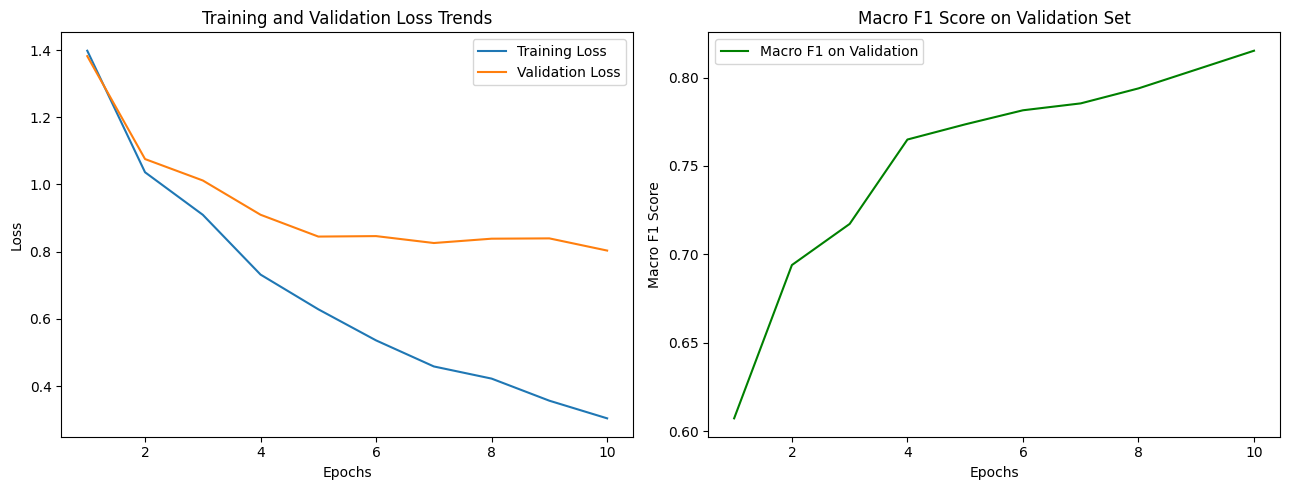

------------------------------
Initiating the Model Testing Phase...


<ipython-input-8-5b7534eb6b90>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.model_directory, 'final_model.pkl')))


test_loss: 0.803 | micro f1 on test: 0.8152


<ipython-input-7-be9bdf089bfe>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  file.write(f"{start_index + i}\t{id_to_relation[int(prediction)]}\n")


Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : <e1>UOM</e1> is<e2>University of Manchester</e2>.
Inferred Relation: Product-Producer(e2,e1)
Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : <e1>Apple</e1> is on the<e2>tree</e2>.
Inferred Relation: Entity-Origin(e1,e2)
Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : exit


In [ ]:
if __name__ == "__main__":
    config = Configuration()
    print("-" * 30)
    print("Operational Configuration Settings:")
    config.display_settings()

    print("-" * 30)
    print("Loading and Processing Data...")
    word_to_id, word_embeddings = EmbeddingInitializer(config).prepare_embeddings()
    relation_to_id, id_to_relation, num_classes = RelationIdentifier(config).fetch_relation_data()
    data_distributor = DataDistributor(relation_to_id, word_to_id, config)
    train_loader, dev_loader = (data_distributor.fetch_training_data(), data_distributor.fetch_validation_data()) if config.mode == 1 else (None, None)
    test_loader = data_distributor.fetch_testing_data()
    data_loaders = [train_loader, dev_loader, test_loader]
    print("Data Loading and Preparation Completed!")

    print("-" * 30)
    model = AttentiveLSTM(word_embeddings=word_embeddings, num_classes=num_classes, settings=config).to(config.device)
    loss_func = nn.CrossEntropyLoss()

    if config.mode == 1:
        train_model(model, loss_func, data_loaders, config)

    predicted_labels = evaluate_model(model, loss_func, data_loaders, config)
    write_predictions_to_file(predicted_labels, id_to_relation)

    while True:
      try:
          sentence = input("Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : ")
          if sentence.lower() == 'exit':
            break
          inferred_relation = determine_relation(sentence, model, word_to_id, id_to_relation, config)
          print(f"Inferred Relation: {inferred_relation}")
      except Exception as e:
        print("An error occurred，please try input again.")

In [12]:
#
config = Configuration()
word_to_id, word_embeddings = EmbeddingInitializer(config).prepare_embeddings()
relation_to_id, id_to_relation, _ = RelationIdentifier(config).fetch_relation_data()
model = AttentiveLSTM(word_embeddings=word_embeddings, num_classes=len(relation_to_id), settings=config).to(config.device)
# Load the pre-trained model weights
model.load_state_dict(torch.load(os.path.join(config.model_directory, 'final_model.pkl')))

while True:
    try:
        sentence = input("Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : ")
        if sentence.lower() == 'exit':
            break
        inferred_relation = determine_relation(sentence, model, word_to_id, id_to_relation, config)
        print(f"Inferred Relation: {inferred_relation}")
    except Exception as e:
        print("An error occurred，please try input again.")

<ipython-input-12-bef0f367b51e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.model_directory, 'final_model.pkl')))


Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : <e1>John</e1> works at <e2>Google</e2>.
Inferred Relation: Product-Producer(e2,e1)
Enter a sentence in English or type 'exit' to quit(example <e1>John</e1> works at <e2>Google</e2>.) : exit
